# Background Low-density Parity-check Codes

We start with a Python version of the 5G NR LDPC decoder architecture, which is then used as blueprint for the later CUDA implementation. 
If you are already familiar with the concept of belief propagation (BP) decoding, you can skip this part of the tutorial.

![LDPC Basics](../../figs/tutorial_ldpc_basics.png)
<p style="text-align: center;">Fig. 1: Parity-check matrix and decoding graph of the (7,4) Hamming code.</p>

## Background: Channel Coding in 5G

In 5G NR, there are two major channel coding schemes: [Low-density Parity-check (LDPC)](https://en.wikipedia.org/wiki/Low-density_parity-check_code) and Polar codes. LDPC codes are used for the data channels while Polar codes are used for the control channels. This tutorial focuses only on the LDPC decoder as this is one of the most compute-intensive components in the 5G stack.

LDPC codes have been invented in 1963 by Robert G. Gallager but were long forgotten due to their high decoding complexity. After their rediscovery by MacKay in 1996, they have become the workhorse of many modern communication standards, including 5G NR.

The core idea of LDPC decoding is an iterative algorithm based on belief propagation. These iterations can be easily parallelized as each processing node is independent of the others, making them an ideal candidate for GPU acceleration. For further details on LDPC codes in OAI, we refer to [Romani2020].

A machine learning enhanced version of the LDPC decoder has been proposed in [Nachmani2016] and is available as [Sionna Tutorial on Weighted Belief Propagation Decoding](https://nvlabs.github.io/sionna/phy/tutorials/Weighted_BP_Algorithm.html).


## Overview Decoder Implementation

![LDPC Acceleration Overview](../../figs/tutorial_ldpc_kernel.png)
<p style="text-align: center;">Fig. 2: Overview of the LDPC BP decoding algorithm.</p>

An overview of the LDPC BP decoding algorithm is shown in Fig. 2 above.
The core decoding algorithm is implemented in the *update_cn_kernel(.)* and *update_vn_kernel(.)* functions. Both kernels are iteratively executed and perform the check node (CN) and variable node (VN) updates, respectively. The decoder stops when the maximum number of iterations is reached. An additional early stopping condition could also be applied to reduce the average number of iterations.

*pack_bits_kernel(.)* maps the soft-values to hard-decided bits and packs them into a more compact byte-representation which is required for the OAI processing pipeline.

Note that the decoder is implemented using `int` datatypes instead of `float`. This ensures compatibility with OAI.

The Python code of this tutorial can be also found in [tutorials/ldpc_cuda/python/numpy_decoder.py](https://github.com/NVlabs/sionna-rk/blob/main/tutorials/ldpc_cuda/python/numpy_decoder.py)

### Python Imports

Let us now import the relevant libraries. We use the `LDPC5GEncoder` from Sionna to simplify the code construction. Sionna is not required to run the final CUDA decoder.

In [ ]:
# Import the required libraries
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Set the TF log level to only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np

import matplotlib.pyplot as plt

# Import Sionna LDPCEncoder LDPC code definitions
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder

### Basegraph selection

In 5G NR, the LDPC code is defined by two basegraphs (`bg`) each with 8 different realizations (selected by the lifting set index `ils`) depending on the code length and rate. The basegraph selection must be done during each decoding execution as the code parameters can dynamically change.

The LDPC code construction itself is a quasi-cyclic (QC) LDPC code with lifting factor $Z$ which takes values between 2,...,384. For details see [Richardson2018].

In [2]:
def get_bg(ils, bg, verbose=False):
    """Pre-generates basegraph description for the given lifting set index and basegraph number.

    This can be precomputed and stored before the decoding process.

    Parameters
    ----------
    ils : int | 0,...,7
        lifting set index of bg as defined in 38.212 Tab 5.3.2-1.
    bg : int | 1,2
        Basegraph number
    verbose : bool
        If True, additional information is printed

    Returns
    -------
    bg_vn : list of tuples
        Each tuple contains the variable node index, the check node index, the cyclic shift and the offset for the memory access of the message.
    bg_cn : list of tuples
        Each tuple contains the check node index, the variable node index, the cyclic shift and the offset for the memory access of the message.
    bg_vn_degree : list
        List of variable node degrees.
    bg_cn_degree : list
        List of check node degrees.
    """

    if bg==1:
        bg = "bg1"
    else:
        bg = "bg2"
    # Use sionna to load the basegraph
    enc = LDPC5GEncoder(12, 24) # dummy encoder
    mat_ref = enc._load_basegraph(ils, bg)

    #########################################################
    # Generate bg compact description
    #########################################################

    # From VN perspective
    bg_vn = []
    msg_offset = 0 # Counter how many messages blocks have been passed already
    for idx_vn in range(mat_ref.shape[1]):
        t = []
        for idx_cn in range(mat_ref.shape[0]):
            if mat_ref[idx_cn, idx_vn] != -1:
                t.append((idx_vn, idx_cn, int(mat_ref[idx_cn, idx_vn]),
                          msg_offset))
                msg_offset += 1
        bg_vn.append(t)

    if verbose:
        print(bg_vn)

    # From CN perspective
    bg_cn = []
    for idx_cn in range(mat_ref.shape[0]):
        t = []
        for idx_vn in range(mat_ref.shape[1]):
            if mat_ref[idx_cn, idx_vn] != -1:
                # Find message offset from VN perspective
                # Find matching entry in bg_vn to get message offset
                for vn_entry in bg_vn[idx_vn]:
                    if vn_entry[1] == idx_cn:
                        msg_offset = vn_entry[3]
                        break
                t.append((idx_cn, idx_vn, int(mat_ref[idx_cn, idx_vn]),
                          msg_offset))
        bg_cn.append(t)
    if verbose:
        print(bg_cn)

    bg_vn_degree = [len(bg_vn[i]) for i in range(len(bg_vn))]
    bg_cn_degree = [len(bg_cn[i]) for i in range(len(bg_cn))]

    if verbose:
        print(bg_vn_degree)
        print(bg_cn_degree)

    return bg_vn, bg_cn, bg_vn_degree, bg_cn_degree

This can be be precomputed for $bg=1$ and $bg=2$ and for all possible values of $ils=0,...,7$ leading to 14 different code definitions. For the sake of readability of this Python implementation, we re-run the above function during each call of the decoding function.

Before decoding, the decoder needs to load the exact code configuration for the given basegraph $bg$ and lifting factor $z$.

In [3]:

def init_basegraph(bg, z):
    """Initializes the basegraph, its dimensions and number of edges/messages.

    Parameters
    ----------
    bg : int | 1,2
        Basegraph number
    z : int | 2,...,384
        Lifting factor

    Returns
    -------
    bg_vn : list of tuples
        Each tuple contains the variable node index, the check node index, the cyclic shift and the offset for the memory access of the message.
    bg_cn : list of tuples
        Each tuple contains the check node index, the variable node index, the cyclic shift and the offset for the memory access of the message.
    bg_vn_degree : list
        List of variable node degrees.
    bg_cn_degree : list
        List of check node degrees.
    num_cols : int
        Number of variable nodes.
    num_rows : int
        Number of check nodes.
    num_edges : int
        Number of edges/messages in the graph.
    """

    # These values are hard-coded for the basegraphs bg1 and bg2
    # They are defined the 38.212.
    if bg == 1:
        num_rows = 46
        num_cols = 68
        num_nnz = 316 # Num non-zero elements in bg
    else: # bg2
        num_rows = 42
        num_cols = 52
        num_nnz = 197 # Num non-zero elements in bg

    # Number of variable nodes
    num_vns = num_cols * z
    # Number of check nodes
    num_cns = num_rows * z

    # Number of edges/messages in the graph
    num_edges = num_nnz * z

    # Lifting set according to 38.212 Tab 5.3.2-1
    s_val = [[2, 4, 8, 16, 32, 64, 128, 256],
             [3, 6, 12, 24, 48, 96, 192, 384],
             [5, 10, 20, 40, 80, 160, 320],
             [7, 14, 28, 56, 112, 224],
             [9, 18, 36, 72, 144, 288],
             [11, 22, 44, 88, 176, 352],
             [13, 26, 52, 104, 208],
             [15, 30, 60, 120, 240]]

    # Find lifting set index
    ils = -1
    for i in range(len(s_val)):
        for j in range(len(s_val[i])):
            if z == s_val[i][j]:
                ils = i
                break
    # This case should not happen
    assert ils != -1, "Lifting factor not found in lifting set"

    # Load base graph; this will become a lookup table in CUDA
    bg_vn, bg_cn, bg_vn_degree, bg_cn_degree = get_bg(ils, bg)

    return bg_vn, bg_cn, bg_vn_degree, bg_cn_degree, num_cols, num_rows, num_edges

## Memory Layout

The resulting parity-check matrix after lifting can be visualized using the code below. Each blue dot represents a connection from a check node to a variable node and, thus, an outgoing message from a check node to a variable node which needs to be stored in the message buffer.


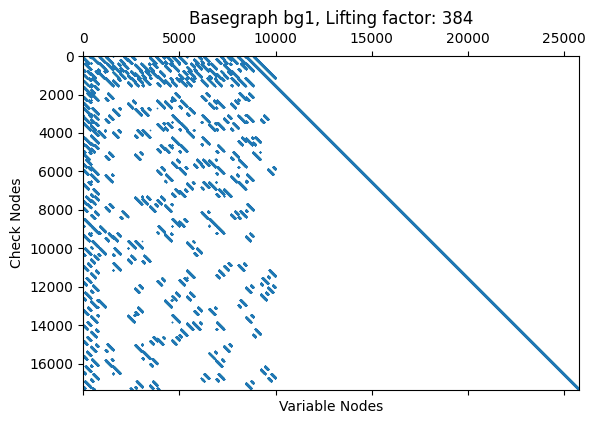

In [4]:
 # Example code construction
k = 8448
n = 368*68
enc = LDPC5GEncoder(k, n)
dec = LDPC5GDecoder(enc)

plt.spy(dec._pcm, markersize=0.3);
plt.xlabel('Variable Nodes');
plt.ylabel('Check Nodes');
plt.title(f'Basegraph {enc._bg}, Lifting factor: {enc._z}');
plt.show();



During decoding, it requires to update three different message buffers:

1. **llr_channel**: This buffer stores the LLRs from the channel. This is of size $Z*68$ for $bg=1$ and $Z*52$ for $bg=2$.
2. **llr_total **: This buffer accumulates the LLRs from the variable nodes. This is of size $Z*68$ for $bg=1$ and $Z*52$ for $bg=2$.
3. **llr_msg**: This buffer stores the messages from the check nodes to the variable nodes. This is of size $Z*316$ for $bg=1$ and $Z*197$ for $bg=2$.

Note that in practice as a result of rate-matching many VNs are punctured. This allows more efficient decoders but not updating these unused VNs.

## CN Update Function

We are using the *min-sum* approximation for the check node update, given as 

$$\qquad y_{j \to i} = \alpha_{j \to i} \cdot \beta \cdot {min}_{i' \in \mathcal{N}(j) \setminus i} \left(|x_{i' \to j}| \right)$$

where $y_{j \to i}$ denotes the message from
check node (CN) $j$ to variable node (VN) $i$ and $x_{i \to j}$ from
VN $i$ to CN $j$, respectively. Further, $\mathcal{N}(j)$ denotes
all indices of connected VNs to CN $j$ and

$$\alpha_{j \to i} = \prod_{i' \in \mathcal{N}(j) \setminus i} \operatorname{sign}(x_{i' \to j})$$

is the sign of the outgoing message. The parameter $\beta$  defines the damping factor which is used to scale the outgoing CN messages.
For further details we refer to [Chen2005].

In [5]:
# In the later CUDA implementation, we use int8 dtypes for the LLRs.
# Thus, we need to clip the LLRs to the range [-127, 127]
MAX_LLR_VALUE = 127 # depends on dtype

# Damping(=scaling) factor of the outgoing LLRs to improve the decoding performance.
# This is a heuristic value and typically a good choice.
DAMPING_FACTOR = 0.75

def update_cn(llr_msg, llr_total, z, bg_cn, bg_cn_degree, num_rows, first_iter):
    """
    Inputs
    ------
    llr_msg: np.array [num_edges]
        Incoming LLRs from variable nodes
    llr_total: np.array [num_vns]
        Accumulated LLRs from variable nodes
    z: int | 2,...,384
        Lifting factor
    bg_cn: list of tuples
        Check node configuration
    bg_cn_degree: list
        Check node degree
    num_rows: int
        Number of rows in the base graph
    first_iter: bool
        Whether this is the first iteration

    Returns
    -------
    llr_msg: np.array [num_edges]
        Updated LLRs from check nodes
    """
    # Check node update function

    # These two loops can be parallelized in CUDA
    for i in range(z): # between 2 and 384
        for idx_row in range(num_rows): # Either 46 or 42

            cn_degree = bg_cn_degree[idx_row] # Check node degree

            # List of tuples (idx_row, idx_col, s, msg_offset)
            cn = bg_cn[idx_row] # len(cn) = cn_degree

            # Search the "extrinsic" min of all incoming LLRs
            # This means we need to find the min and the second min of all incoming LLRs
            min_1 = MAX_LLR_VALUE
            min_2 = MAX_LLR_VALUE
            idx_min = -1
            node_sign = 1

            # Temp buffer for signs
            msg_sign = np.ones((19,)) # Max CN degree is 19

            for ii in range(cn_degree):

                # Calculate the index of the message in the LLR array
                msg_offset = cn[ii][3]
                s = cn[ii][2]
                idx_col = cn[ii][1]
                msg_idx = msg_offset * z + i

                # Total VN message
                t = llr_total[idx_col*z + (i+s)%z]

                # Make extrinsic by subtracting the previous msg
                if not first_iter: # Ignore in first iteration
                    t -= llr_msg[msg_idx]

                # Store sign for 2nd recursion
                sign = 1 if np.abs(t) == 0 else np.sign(t)

                # Could be also used for syndrome-based check or early termination
                node_sign *= sign
                msg_sign[ii] = sign # For later sign calculation

                # Find min and second min
                t_abs = np.abs(t)

                if t_abs < min_1:
                    min_2 = min_1
                    min_1 = t_abs
                    idx_min = msg_idx
                elif t_abs < min_2:
                    min_2 = t_abs

            # Apply damping factor
            min_1 *= DAMPING_FACTOR
            min_2 *= DAMPING_FACTOR

            # Clip min_val to MAX_LLR_VALUE
            min_1 = np.clip(min_1, -MAX_LLR_VALUE, MAX_LLR_VALUE)
            min_2 = np.clip(min_2, -MAX_LLR_VALUE, MAX_LLR_VALUE)

            # Apply min and second min to the outgoing LLR
            for ii in range(cn_degree):
                msg_offset = cn[ii][3]

                msg_idx = msg_offset * z + i
                if msg_idx == idx_min:
                    min_val = min_2
                else:
                    min_val = min_1

                # And update outgoing msg including sign
                llr_msg[msg_idx] = min_val * node_sign * msg_sign[ii]

    return llr_msg

## VN Update Function

The variable node update function sums all incoming messages from the check nodes and adds the channel LLRs

$$x_{i \to j} = \sum_{j' \in \mathcal{M}(i) \setminus j} y_{j' \to i} + \lambda_i$$

where $\lambda_i$ denotes the channel LLR associated to the $i$-th VN and $\mathcal{M}(i) \setminus j$ denotes the set of check nodes connected to VN $i$ excluding the check node $j$ itself.

In [6]:
def update_vn(llr_msg, llr_ch, llr_total, z, bg_vn, bg_vn_degree, num_cols):
    """
    Inputs
    ------
    llr_msg: np.array [num_edges]
        Incoming LLRs from check nodes
    llr_ch: np.array [num_vns]
        Channel LLRs
    llr_total: np.array [num_vns]
        Accumulated LLRs from variable nodes
    z: int | 2,...,384
        Lifting factor
    bg_vn: list of tuples
        Variable node configuration
    bg_vn_degree: list
        Variable node degree
    num_cols: int
        Number of variable nodes

    Returns
    -------
    llr_total: np.array [num_vns]
        Updated LLRs from variable nodes

    """

    # This can be parallelized in CUDA
    for i in range(z): # Between 2 and 384
        for idx_col in range(num_cols): # Either 52 or 68

            vn_degree = bg_vn_degree[idx_col] # Variable node degree

            # List of tuples (idx_col, idx_row, s, msg_offset)
            vn = bg_vn[idx_col] # len(vn) = vn_degree

            # Accumulate all incoming LLRs
            msg_sum = 0 # Should be int16
            for j in range(vn_degree):

                msg_offset = vn[j][3]
                s = vn[j][2]

                # Index of the msg in the LLR array
                # It is the idx_col-th variable node, and the j-th message from the idx_row-th check node
                msg_idx = msg_offset * z + (i-s)%z
                # Accumulate all incoming LLRs
                msg_sum += llr_msg[msg_idx].astype(np.int16)

            # Add the channel LLRs
            msg_sum += llr_ch[idx_col*z + i].astype(np.int16)

            llr_total[idx_col*z + i] = msg_sum

    return llr_total

## Hard-decision

The final LLRs can now be hard-decided to bits. Further, OAI requires to return bytes instead of bit values.


In [7]:
def pack_bits(llr_total, block_length, pack_bits=False):
    """
    Inputs
    ------
    llr_total: np.array [num_vns]
        LLRs from variable nodes
    block_length: int
        Number of payload bits that are returned after decoding
    pack_bits: bool
        If True, the bits are packed into a byte array

    Returns
    -------
    bits: np.array [block_length]
        Decoded bits
    """

    # OAI wants the bits in a byte array
    if pack_bits:
        # Round length to the nearest multiple of 8
        block_length = int(np.ceil(block_length/8)*8)
        bits = (llr_total[:block_length]<0).astype(np.uint8)
        bits = np.packbits(bits)
    else:
        bits = (llr_total[:block_length]<0).astype(np.uint8)

    return bits

## Main Decoding Function

We can now run the full LDPC decoder by iteratively updating VN and CN update functions as depicted in Fig. 2.

In [8]:
def decode_ldpc(bg, z, block_length, num_iter, llr_ch):
    """
    Inputs
    ------
    bg: int | 1,2
        Basegraph used for decoding

    z: int | 2,...,384
        Lifting factor

    block_length: int
        Number of payload bits that are returned after decoding

    num_iter: int
        Max number of decoding iterations

    llr_ch: np.array [68+z] or [52*z] for bg1 and bg2, respectively
        Received channel LLRs
    """


    ############################
    # Initialize Variables
    ############################

    bg_vn, bg_cn, bg_vn_degree, bg_cn_degree, num_cols, num_rows, num_edges = init_basegraph(bg, z)

    # Temporary message buffer
    # Max size is 316*384
    llr_msg = np.zeros((num_edges,), dtype=np.int8) # No need to initialize to 0

    # VN accumulator
    # We always init the max size of the LLR array given as 68*384
    # The accumulator needs higher precision than the message buffer

    llr_ch = llr_ch.astype(np.int8)

    ############################
    # Main Decoding Loop
    ############################
    llr_total = np.copy(llr_ch).astype(np.int16) # llr_total will be updated in the VN update

    for i in range(num_iter):

        # CN update
        # llr_msg not read, only written to in first iteration; will be filled with outputs of this function
        llr_msg = update_cn(llr_msg, llr_total, z, bg_cn, bg_cn_degree, num_rows, i==0)

        # VN update
        llr_total = update_vn(llr_msg, llr_ch, llr_total, z, bg_vn, bg_vn_degree, num_cols)

    # Pack bits
    bits = pack_bits(llr_total, block_length, pack_bits=True)

    # [optional] apply syndrome check and if not successful return `num_iter+=1``

    return bits, llr_total

## Run and Test the Decoder

We can now run an end-to-end test of the decoder using the Sionna `LDPC5GEncoder`. Note that de-rate matching at the receiver must be done manually before decoding. This will be handled by the OAI stack in the future.


In [9]:
# Parameters
k = 1280 # Payload size
n = 2560 # Codeword size after rate matching
num_iter = 8 # Number of decoding iterations
llr_mag = 10 # LLR magnitude

# Use Sionna for BG selection
enc = LDPC5GEncoder(k, n)
bg = 1 if enc._bg == "bg1" else 2
z = enc._z

# Draw random bits
u = np.random.randint(0,2,k)

# Encode using Sionna
c = enc(np.expand_dims(u.astype(np.float32),0))[0].numpy()

# Map to LLRs
x = 1-2*c

# Clip to max LLR value due to int8 representation
llr_ch = np.clip((llr_mag * x),-127,127).astype(np.int8)

# Get code parameters
num_vn = 68*z if bg == 1 else 52*z
parity_start = 22*z if bg == 1 else 10*z

# Apply rate matching
llr_input = np.zeros(num_vn,dtype=np.int8) # Takes care of the punctured bits (initialized to 0 LLR)
llr_input[2*z:k] =  llr_ch[:k-2*z] # Unpunctured message bits
llr_input[k:parity_start] = 127      # Shortened bits
llr_input[parity_start:parity_start+n-k+2*z] = llr_ch[k-2*z:] # parity bits

# Run decoder
decoder_outputs,_ = decode_ldpc(bg, z, k, num_iter, llr_input)

# Evaluate results
u_hat = np.unpackbits(decoder_outputs.astype(np.uint8))[:k] # There may be a couple of extra bits if k is not a multiple of 8
if np.all(u == u_hat):
    print("All payload bits decoded correctly!")
else:
    print("Decoding failed!")

print(f"Shape of LLR input: {llr_input.shape}")
print(f"Shape of decoded bytes: {decoder_outputs.shape}")

All payload bits decoded correctly!
Shape of LLR input: (6656,)
Shape of decoded bytes: (160,)


We are now ready to start with the CUDA implementation!